In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skimage.draw import polygon
import PIL
import json
import base64
import os.path
from os.path import splitext
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
#https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html
from keras_segmentation.models.segnet import segnet
from keras_segmentation.models.unet import unet
from keras.models import model_from_json
from keras.models import load_model, save_model

Using TensorFlow backend.


In [3]:
categories = {1: "Strasse", 
              2: "Streifen",
              3: "Auto", 
              4: "Schild",           
         }


colors = {0 : (0,0,0), 
          1 : (0,0,255), 
          2 : (0,255,0),
          3 : (255,0,0), 
          4 : (0,255,255),         
         }

dim = (256, 256) 


path =  r'/home/inf/Bilder/Road'

dirmodels = "models"
dirimagestest = "images_test"
dirmaskstest = "masks_test"


fullpathimagestest = os.path.join(path, dirimagestest)
fullpathmaskstest = os.path.join(path, dirmaskstest)

In [7]:
imagetestlist = []

imagetestnames = os.listdir(fullpathimagestest)
imagetestnames.sort()

for imagename in imagetestnames:
    if imagename.endswith(".png"):
        imagetestlist.append(cv2.imread(os.path.join(fullpathimagestest,imagename),cv2.IMREAD_COLOR ))

In [5]:
#modelweightname = "modelaugmented.h5"
modelweightname = "roadunet256-lib.h5"
#modelweightname = "modelsegnet256.h5"

#model = segnet(20, input_height=200, input_width=200)
model = unet(len(colors), input_height=dim[0], input_width=dim[1])

model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [8]:
j = 1
out = model.predict_segmentation(
    inp=imagetestlist[j],
)

In [9]:
def makemask(mask):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], 3), 'uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
                assert(mask[i,j] < len(colors))
                ret_mask[i,j,0] = colors[mask[i,j]][0]
                ret_mask[i,j,1] = colors[mask[i,j]][1]
                ret_mask[i,j,2] = colors[mask[i,j]][2]
    return ret_mask

In [10]:
def makemaskcolor(mask, color):
    ret_mask = np.zeros((mask.shape[0], mask.shape[1], 3), 'uint8')
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
                if mask[i,j] == color:
                    ret_mask[i,j,0] = colors[color][0]
                    ret_mask[i,j,1] = colors[color][1]
                    ret_mask[i,j,2] = colors[color][2]
    return ret_mask

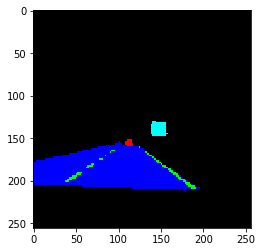

In [11]:
img = makemask(out)

assert(img.shape[0] == img.shape[1])

mask = np.zeros((dim[0], dim[1], 3), 'uint8')

mask = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

plt.imshow(mask)

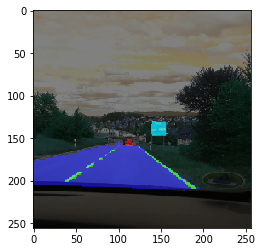

In [12]:
weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
cv2.addWeighted(imagetestlist[j], 0.5, mask, 0.5, 0, weighted)
plt.imshow(weighted)

In [27]:
cap = cv2.VideoCapture(os.path.join(path,"videos",'VID_20200503_174243.mp4'))
if (cap.isOpened() == True): 
    
    print("Opening video stream or file")
    out = cv2.VideoWriter(os.path.join(path,"videos",'video4.mp4'),cv2.VideoWriter_fourcc(*'MP4V'), 25, (256,256))
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        edge = min(frame.shape[0],frame.shape[1])
        
        img_sq = np.zeros((edge, edge, 3), 'uint8')

        
        if(edge == frame.shape[0]):
            img_sq[:,:,:] = frame[:,int((frame.shape[1] - edge)/2):int((frame.shape[1] - edge)/2)+edge,:]
        else:
            img_sq[:,:,:] = frame[int((frame.shape[0] - edge)/2):int((frame.shape[0] - edge)/2)+edge,:,:]
            
        assert(img_sq.shape[0] == edge and img_sq.shape[1] == edge)
        
        img_resized = np.zeros((256, 256, 3), 'uint8')  
        img_resized = cv2.resize(img_sq, (256,256), interpolation = cv2.INTER_AREA) 
        
        img_resized = cv2.flip(img_resized, -1)
        
        if ret == True:
            out.write(img_resized)
            cv2.imshow('Frame',img_resized)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

    out.release()
            
cap.release()
cv2.destroyAllWindows()

Opening video stream or file


In [14]:
cap.release()
cv2.destroyAllWindows()

In [31]:
cap = cv2.VideoCapture(os.path.join(path,"videos",'video4.mp4'))
if (cap.isOpened() == True): 
    
    print("Opening video stream or file")
    out = cv2.VideoWriter(os.path.join(path,"videos",'video4-weighted.mp4'),cv2.VideoWriter_fourcc(*'MP4V'), 25, (dim[0],dim[1]))
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        pic = model.predict_segmentation(inp=frame)
        
        if ret == True:
            
            mask = makemask(pic)

            mask1 = np.zeros((dim[0], dim[1], 3), 'uint8')
            mask1 = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA) 
            
            weighted = np.zeros((dim[0], dim[1], 3), 'uint8')
            cv2.addWeighted(frame, 0.6, mask1, 0.4, 0, weighted)

            out.write(weighted)
            cv2.imshow('Frame',weighted)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

    out.release()
            
cap.release()
cv2.destroyAllWindows()

Opening video stream or file


# Unet Model 128

In [3]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:
modeljsonname="modelunet128-3.json"
modelweightname="modelunet128-3.h5"

In [9]:
def predictedmask(mask):

    assert mask.shape == (dim[0], dim[1], len(colors))
    imgret = np.zeros((dim[0], dim[1]), np.uint8)
    for i in range(dim[0]):
        for j in range(dim[1]):
            result = np.where(mask[i,j,:] == np.amax(mask[i,j,:]))
            assert result[0][0] < len(colors)
            imgret[i,j] = result[0][0]
  
    return imgret

In [10]:
json_file = open(os.path.join(path, dirmodels,modeljsonname), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(os.path.join(path, dirmodels,modelweightname))

In [13]:
cap = cv2.VideoCapture(os.path.join(path,"videos",'video2.mp4'))
if (cap.isOpened() == True): 
    
    print("Opening video stream or file")
    out = cv2.VideoWriter(os.path.join(path,"videos",'videounet128-3-1.mp4'),cv2.VideoWriter_fourcc(*'MP4V'), 25, (256,256))
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == False:
            break
        
        frame_resized = np.zeros((dim[0], dim[1], 3), 'uint8')  
        frame_resized = cv2.resize(frame, (dim[0],dim[1]), interpolation = cv2.INTER_AREA) 
        test_data = []
        test_data.append(frame_resized)
        test_data = np.array(test_data, dtype=np.float32)
        test_data -= test_data.mean()
        test_data /= test_data.std()
        
        predicted = model.predict(test_data, batch_size=1, verbose=0)
        assert(len(predicted) == 1)
        pmask = predictedmask(predicted[0])
        
        if ret == True:
            img = markpicture(pmask, frame)
            out.write(img)
            cv2.imshow('Frame',img)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

    out.release()
            
cap.release()
cv2.destroyAllWindows()

Opening video stream or file


In [17]:
out.release()